# Load Saved SVC

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

svc = None
X_train_scaler = None

with open('svm.p', 'rb') as f:
    data = pickle.load(f)
    svc = data['svm']
    X_train_scaler = data['scaler']
    orient = data['orient'] 
    pix_per_cell = data['pix_per_cell']
    cell_per_block = data['cell_per_block']
    spatial_feat = data['spatial_feat']
    hist_feat = data['hist_feat']
    hog_feat = data['hog_feat']
    hog_channel = data['hog_channel']
    color_space = data['color_space']

color_space_code = eval('cv2.COLOR_RGB2' + color_space)

def get_box_features(box_img_lab):
    if box_img_lab.shape[0] != 64 or box_img_lab.shape[1] != 64:
        raise Exception("Image has to be 64 x 64")
        
    features = extract_feature_image(box_img_lab, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, hog_channel=hog_channel,
                               spatial_feat = spatial_feat,
                               hist_feat = hist_feat,
                               hog_feat = hog_feat)
    
    # normalize features of the box using the same parameters as were used while training
    return X_train_scaler.transform([np.ravel(features)])

def has_car(img_lab, box):
    box_img_64 = get_box_pixels(img_lab, box)
    features = get_box_features(box_img_64)
    return svc.predict(features)


print('SVM loaded: svc')
print('Scaler loaded: X_train_scaler')
print('Color Space:', color_space)

SVM loaded: svc
Scaler loaded: X_train_scaler
Color Space: LAB


## Different Sliding Window Sizes

In [2]:
import matplotlib.pyplot as plt
from lesson_functions import *

%reload_ext autoreload
%autoreload 2

def get_box_pixels(img, box):
    box_img = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]
    box_img_64 = cv2.resize(box_img, (64,64))    
    return box_img_64


# def big_box(img, draw_color = None, no_of_boxes = None, offset = (-0.2, 0)):
#     #x_start = img.shape[1] - 600
#     #x_stop = img.shape[1] - 120
#     x_start = 80
#     x_stop = img.shape[1] - x_start
#     y_start = 440
#     y_stop = img.shape[0]
#     box = (250,200)
    
#     return get_boxes(img, 
#           x_start_stop = (x_start, x_stop), 
#           y_start_stop = (y_start, y_stop),
#           box=box, 
#           draw_color = draw_color, 
#           no_of_boxes = no_of_boxes, 
#           offset_factor=offset)


def medium_box(img, draw_color = None, no_of_boxes = None, offset = (-0.4, 0)):
    #x_start = 660
    x_start = 0
    x_stop = img.shape[1]
    y_start = 400
    y_stop = 600
    box=(175,160)

    return get_boxes(img, 
          x_start_stop = (x_start, x_stop), 
          y_start_stop = (y_start, y_stop),
          box=box, 
          draw_color = draw_color, 
          no_of_boxes = no_of_boxes,
          offset_factor = offset)
    
def small_box(img, draw_color = None, no_of_boxes = None, offset = (-0.3, 0.5)):
    #x_start = 600
    x_start = 0
    x_stop = img.shape[1]
    y_start = 390
    y_stop = 550
    box=(160,120)

    return get_boxes(img, 
          x_start_stop = (x_start, x_stop), 
          y_start_stop = (y_start, y_stop),
          box=box, 
          draw_color=draw_color, 
          no_of_boxes = no_of_boxes,
          offset_factor = offset)


def smallest_box(img, draw_color = None, no_of_boxes = None, offset = (-0.2, 0.2)):
    #x_start = 600
    x_start = 100
    x_stop = img.shape[1] - 100
    y_start = 400
    y_stop = 480
    box=(80,70)

    return get_boxes(img, 
          x_start_stop = (x_start, x_stop), 
          y_start_stop = (y_start, y_stop),
          box=box, 
          draw_color = draw_color, 
          no_of_boxes = no_of_boxes,
          offset_factor=offset)
    
def get_all_boxes(img):
    boxes = []
    #boxes.extend(big_box(img))
    boxes.extend(medium_box(img))
    boxes.extend(small_box(img))
    boxes.extend(smallest_box(img))
    return boxes

print('Functions defined for different box sizes')

Functions defined for different box sizes


## Check Window Sizes

Testing on 1 files


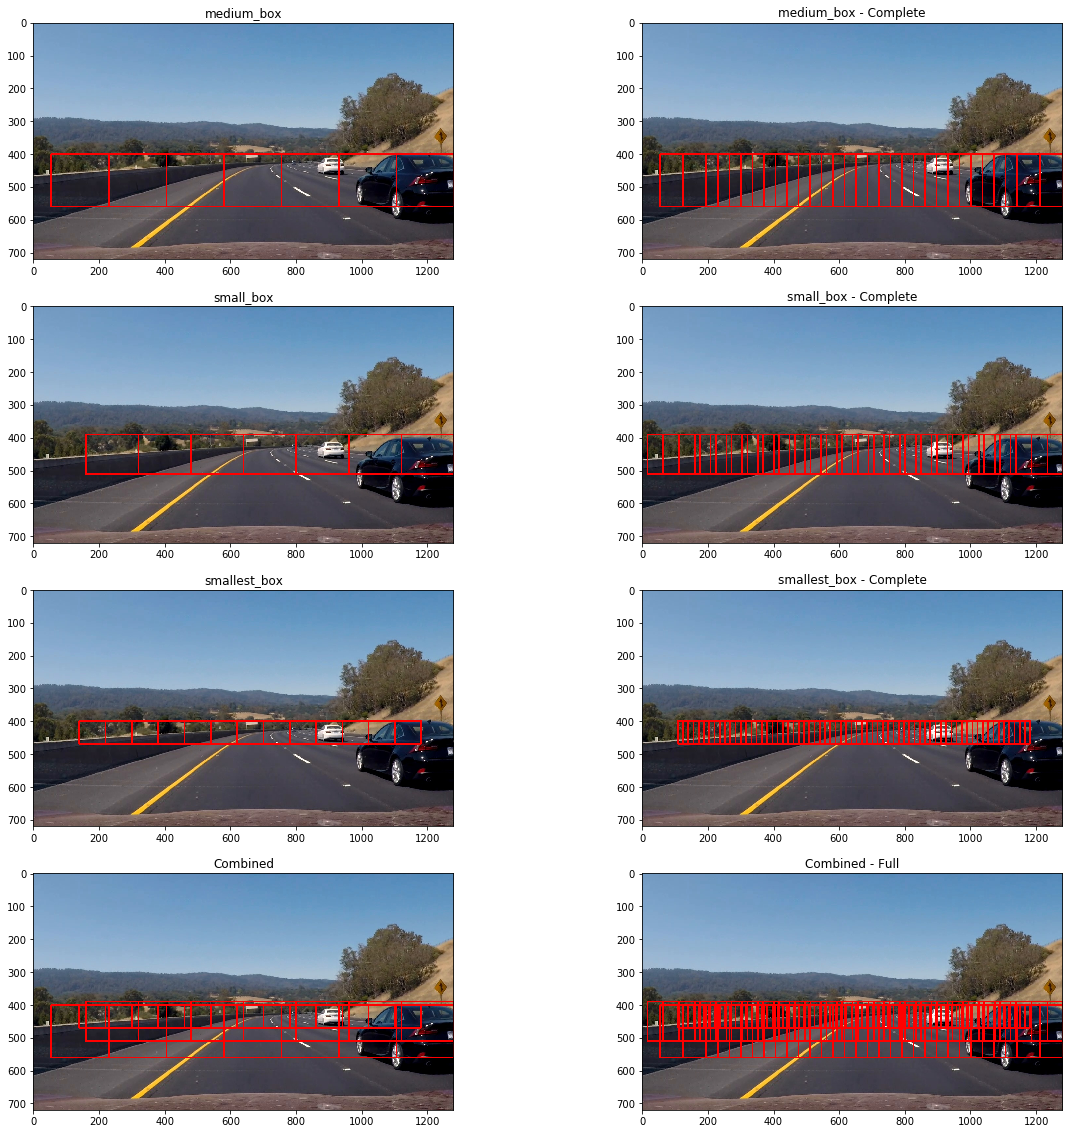

In [3]:
def draw_box_ax(img, boxes, ax, title):
    img = np.copy(img)
    for box in boxes:
        cv2.rectangle(img, box[0], box[1], (255,0,0), 4)
    ax.set_title(title)
    ax.imshow(img)

def show_box_sizes(filename, loaders):
    test_image = load_image(filename, 'RGB')
    
    f, ax = plt.subplots(len(loaders) + 1, 2, figsize=(20,20))
    
    single_boxes = []
    full_boxes = []
    
    for i, loader in enumerate(loaders):
        boxes = loader(test_image, offset = (-1,0))
        single_boxes.extend(boxes)
        draw_box_ax(test_image, boxes, ax[i,0], str(loader).split(' ')[1])

        boxes = loader(test_image)
        full_boxes.extend(boxes)
        draw_box_ax(test_image, boxes, ax[i,1], str(loader).split(' ')[1] + ' - Complete')

    draw_box_ax(test_image, single_boxes, ax[len(loaders), 0], 'Combined')
    draw_box_ax(test_image, full_boxes, ax[len(loaders), 1], 'Combined - Full')
    
        
#test_images = glob.glob('./test_images/*.jpg')
test_images = ['./test_images/0729.jpg']
print('Testing on {} files'.format(len(test_images)))

for filename in test_images:
    show_box_sizes(filename, [medium_box, small_box, smallest_box])

plt.show()
plt.close('all')

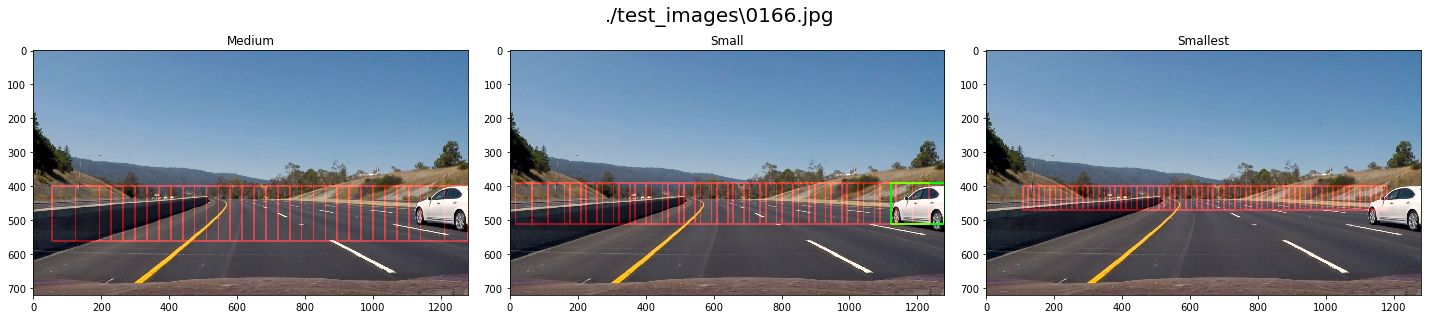

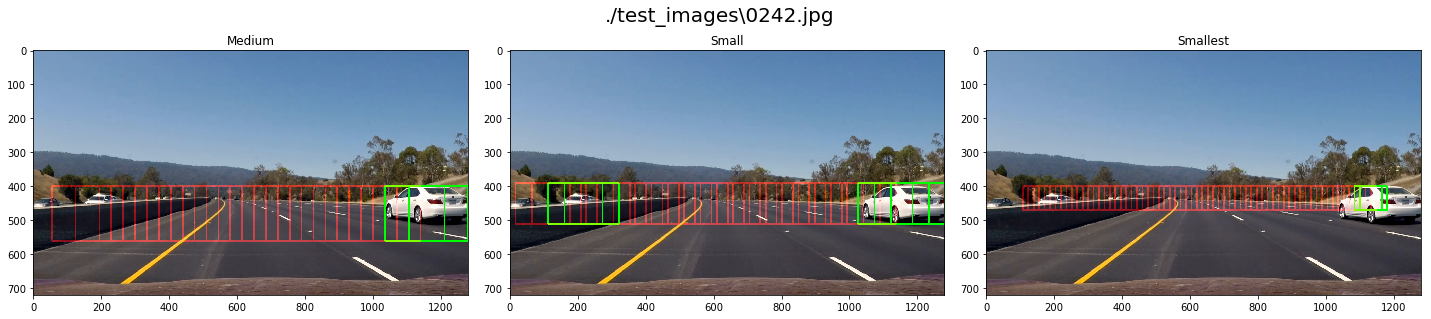

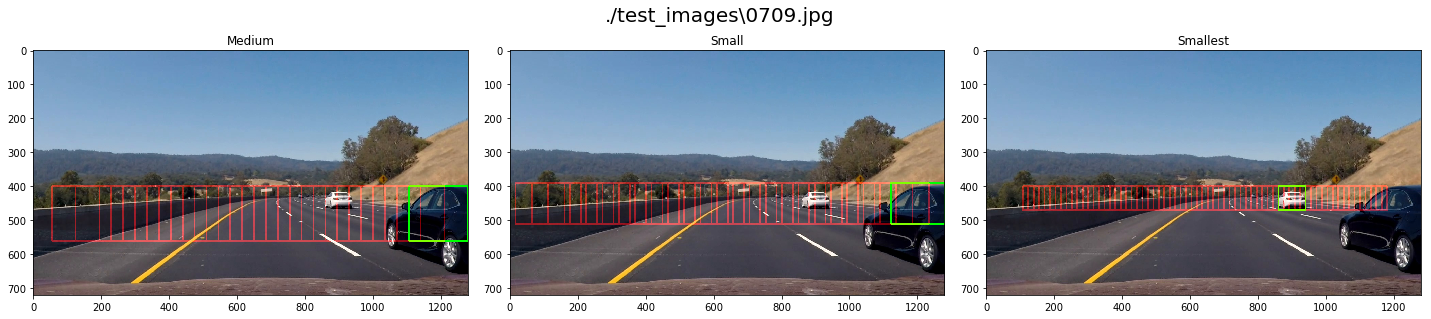

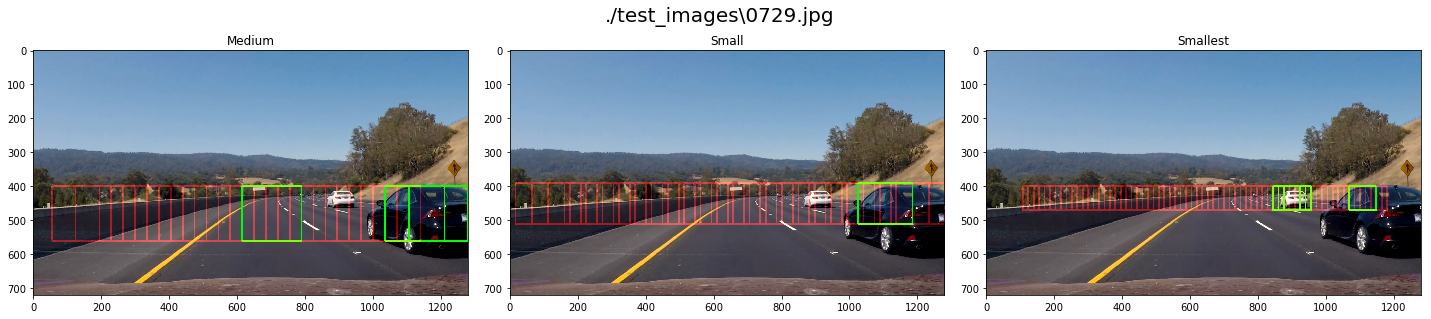

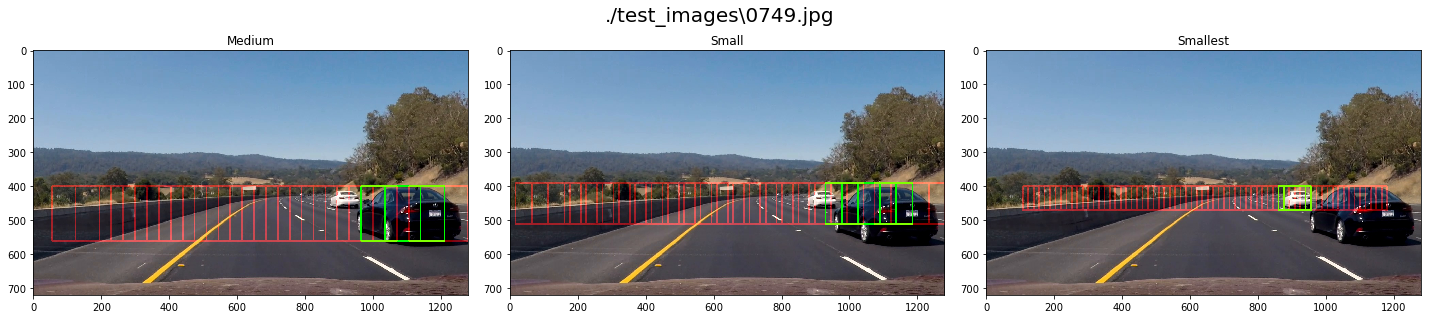

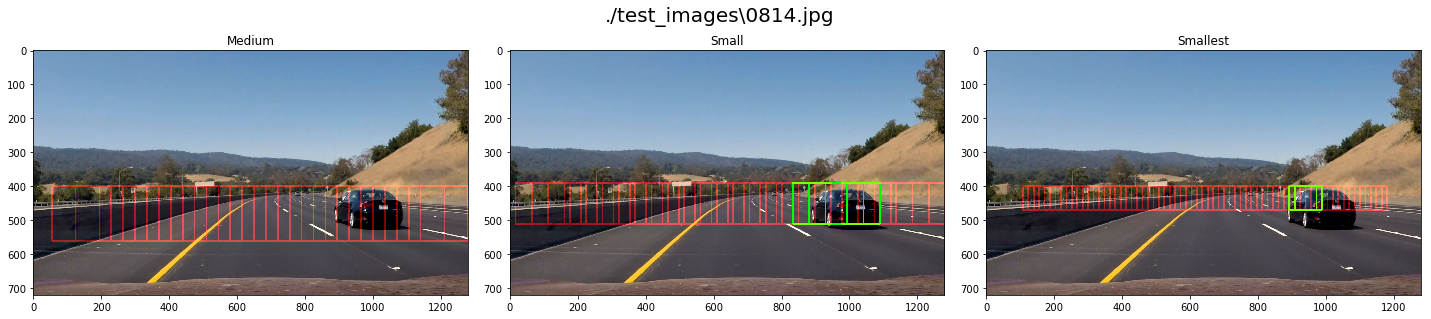

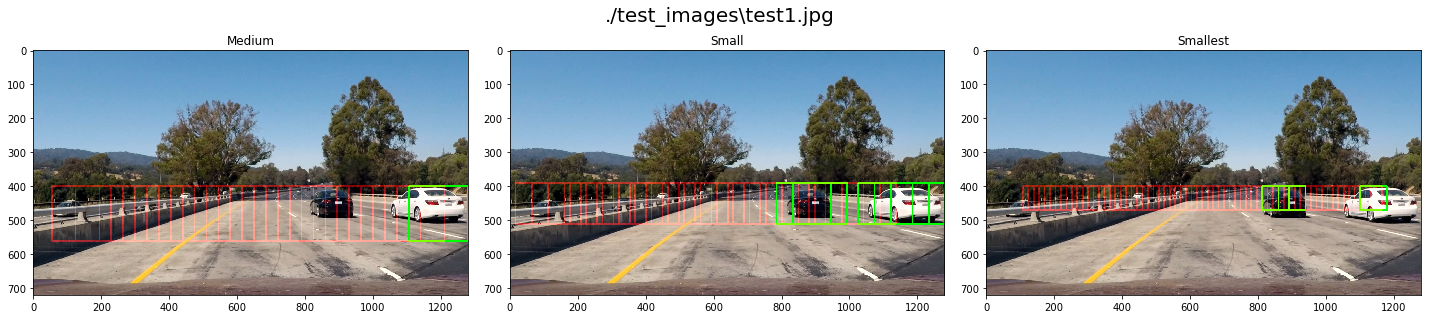

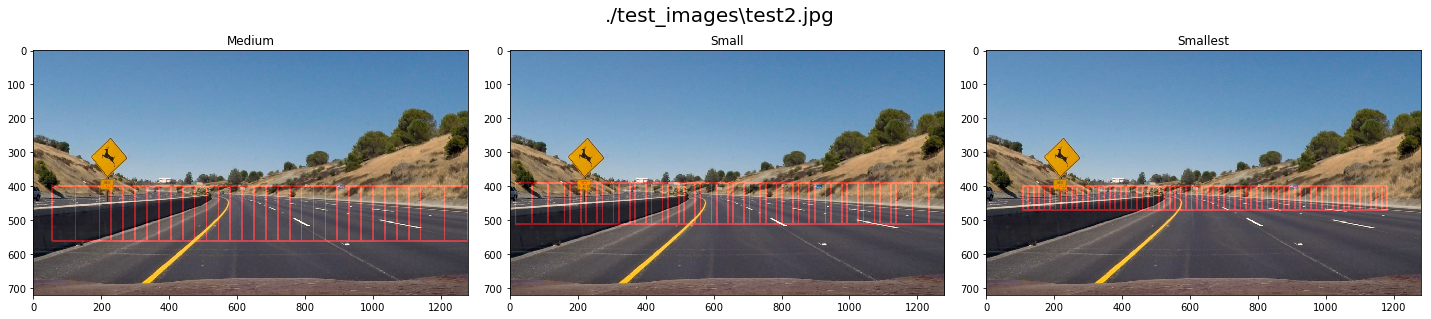

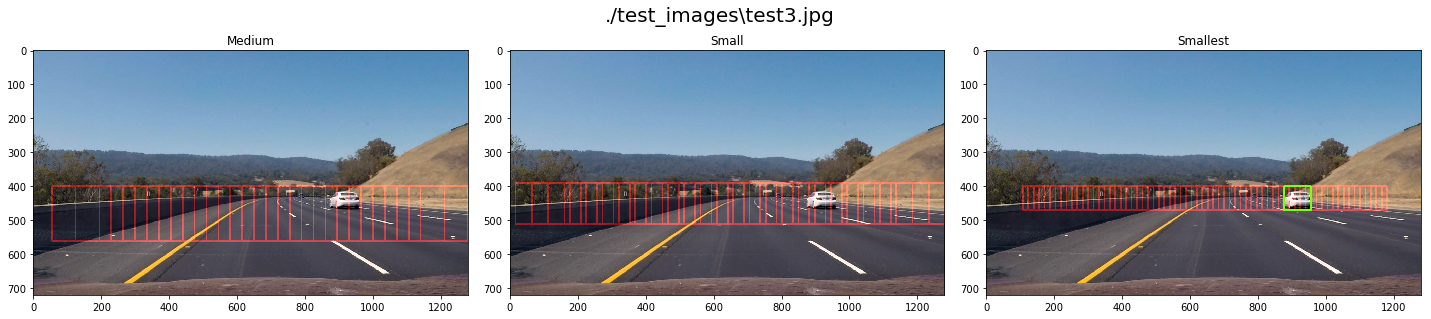

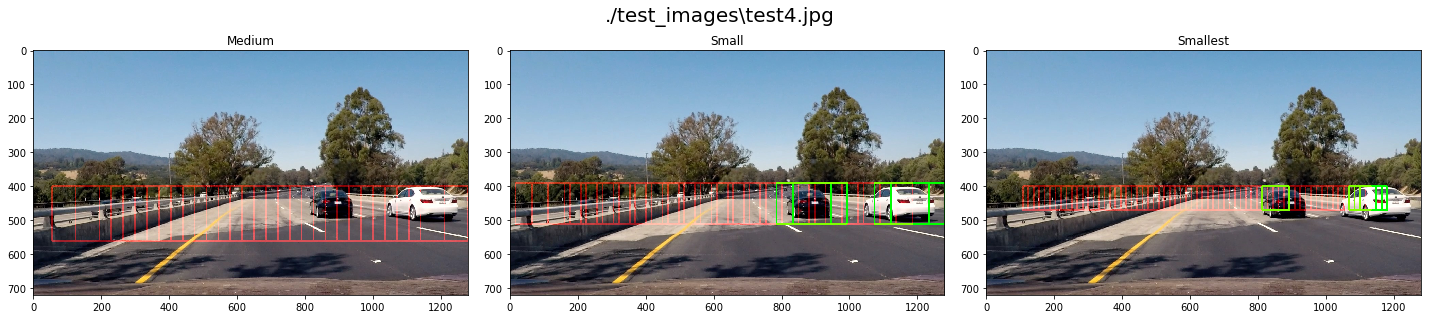

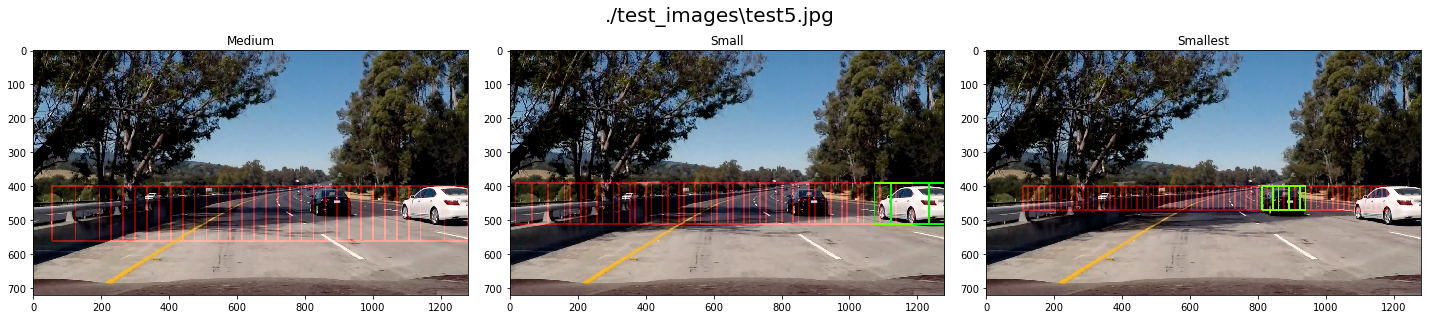

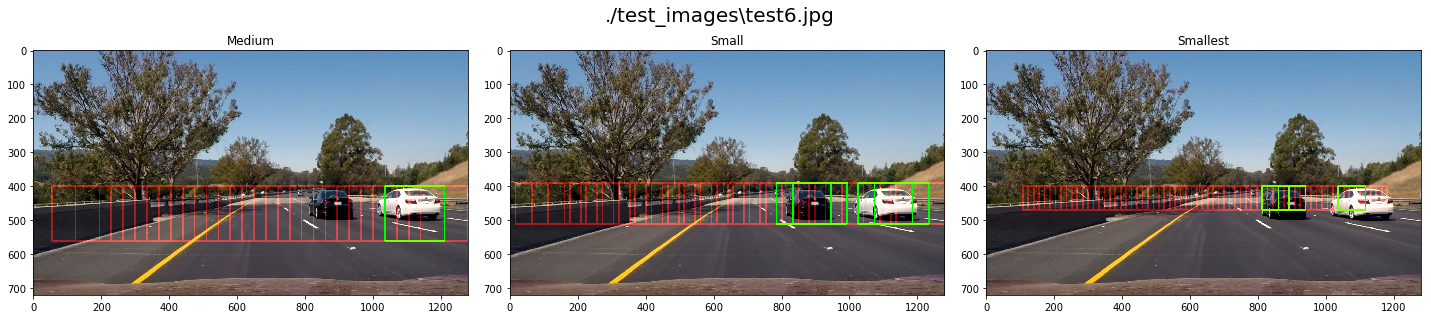

In [4]:
def show_different_boxes(filename):
    img = load_image(filename, 'RGB')
    
    f, ax = plt.subplots(1, 3, figsize=(20,5))
    f.suptitle(filename, fontsize=20)
    f.tight_layout()

    #show_boxes_with_car(img, big_box(img), 'Big', ax[0])
    show_boxes_with_car(img, medium_box(img), 'Medium', ax[0])
    show_boxes_with_car(img, small_box(img), 'Small', ax[1])
    show_boxes_with_car(img, smallest_box(img), 'Smallest', ax[2])

    plt.show()

def show_boxes_with_car(img, boxes, title, ax):
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    canvas = np.copy(img)
    canvas2 = np.zeros_like(img)
    
    for box in boxes:
        if has_car(img_lab, box):
            cv2.rectangle(canvas, box[0], box[1], (0,255,0), 4)
        else:
            cv2.rectangle(canvas2, box[0], box[1], (255,0,0), 4)

    canvas = cv2.addWeighted(canvas, 1, canvas2, 0.5, 0)
    ax.imshow(canvas)
    ax.set_title(title)
    

#test_images = ['./test_images/0242.jpg']
test_images = glob.glob('./test_images/*.jpg')
#print('Testing on {} files'.format(len(test_images)))

for filename in test_images:
    show_different_boxes(filename)

plt.show()
plt.close('all')

## False Positives

This cell can be used to manually inspected false positives (if any)

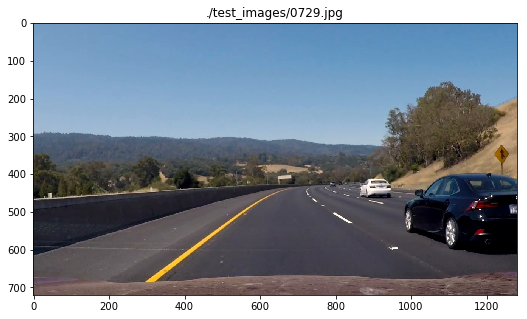

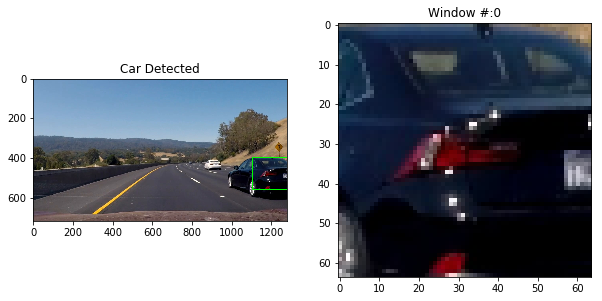

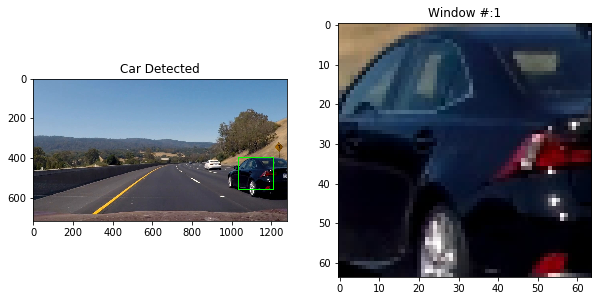

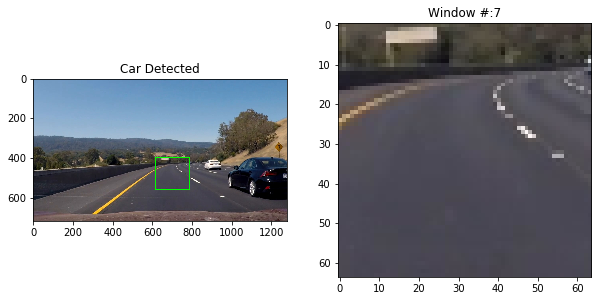

In [19]:
import os

class ProblemBox:
    def __init__(self, filename, loader = smallest_box):
        self.filename = filename
        self.img = load_image(filename, 'RGB')
        self.img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        self.boxes = loader(self.img)
        
    def show_specific_box(self, box_no, color=(255,0,0)):
        img_copy = np.copy(self.img)

        box = self.boxes[box_no]
        cv2.rectangle(img_copy, box[0], box[1], color, 4)

        box_img = get_box_pixels(img, box)
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.imshow(img_copy)
        ax1.set_title('Car Detected')
        ax2.imshow(box_img)
        ax2.set_title('Window #:{}'.format(box_no))
        return box_img
            

    def get_box_filename(self, box_no):
        basename = os.path.basename(self.filename)
        file_no_ext = os.path.splitext(basename)[0]
        return './problem/{}-{}.jpg'.format(file_no_ext, box_no)

    def save_box(self, box_no):
        output = self.get_box_filename(box_no)
        box = self.boxes[box_no]
        box_img = get_box_pixels(self.img, box)
        box_img_bgr = cv2.cvtColor(box_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output, box_img_bgr)
        print(output)

    def show_box_nos(self, box_nos):
        for box_no in box_nos:
            self.show_specific_box(box_no)
            self.save_box(box_no)
        
    def show_all_cars(self, save = False):
        for box_no, box in enumerate(self.boxes):
            if has_car(self.img_lab, box):
                self.show_specific_box(box_no, color=(0,255,0))

                if save:
                    self.save_box(box_no)
                    print(output)

test_images = glob.glob('./test_images/0729.jpg')
img = load_image(test_images[0], 'RGB')

f, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(img)
ax.set_title(test_images[0])
plt.show()

for filename in test_images:
    pb = ProblemBox(filename, medium_box)
    pb.show_all_cars()
    #pb.show_box_nos([14,15,16])
    
plt.show()
plt.close('all')

# Heatmap Test

In [ ]:
import glob
from scipy.ndimage.measurements import label

def detect_cars(img, all_boxes = False):
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    boxes = get_all_boxes(img_lab)
    car_boxes = []
    notcar_boxes = []
    
    for box in boxes:
        if has_car(img_lab, box):
            car_boxes.append(box)
        else:
            notcar_boxes.append(box)
            
    if not all_boxes:
        return car_boxes
    else:
        return car_boxes, notcar_boxes

def heatmap_threshold(heatmap, threshold):
    heatmap[heatmap < threshold] =  0
    
def add_heat(heatmap, boxes):
    for box in boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
def show_heatmap(heatmap):
    heatmap_red = np.dstack(((heatmap * 255/10), np.zeros_like(heatmap), np.zeros_like(heatmap)))
    plt.imshow(heatmap_red)
    
def draw_labeled_bboxes(img, heatmap):
    labels = label(heatmap)
    
    colors = [(255,0,0), (0,255,0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
              (255, 0, 255), (255, 150, 0), (255, 0, 150), (150, 75, 0), (150, 0, 75)]

    labels_img = np.zeros_like(img)
    
    # add more colors to the array in case there are more labels than number of defined colors
    if labels[1] == len(colors):
        extra = labels[i] - len(colors)
        colors.extend([(255,0,0)] * extra)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        mask = labels[0] == car_number
        labels_img[mask] = colors[car_number - 1]
        
        nonzero = (mask).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return labels_img

def get_heat_img(img, heatmap):
    hot_colors = [(90,0,0), (212,0,0), (255, 63, 0), (255,103,0), (255,225,0), (255,225,0), (255,225,0)]

    heat_clipped = np.clip(heatmap, 0, 255)
    max_heat = np.max(heat_clipped)
    if max_heat >= len(hot_colors):
        heatmap = (heatmap / max_heat * len(hot_colors)).astype(np.int_)
    
    heat_img = np.zeros(shape=(heatmap.shape[0], heatmap.shape[1], 3)).astype(np.uint8)
    
    for index in range(0, len(hot_colors)):
        locations = np.where(heatmap == index + 1)
        heat_img[locations[0], locations[1]] = hot_colors[index]
    
    return cv2.addWeighted(img, 0.4, heat_img, 0.6, 0)
    #return heat_img

def draw_car_notcar(img, car_boxes, boxes):
    for box in notcar_boxes:
        cv2.rectangle(img, box[0], box[1], (255,0,0), 4)
    for box in car_boxes:
        cv2.rectangle(img, box[0], box[1], (0,255,0), 6)
    
#test_images = glob.glob('./test_images/*.jpg')
test_images = ['./test_images/0729.jpg']
print('Testing on {} files'.format(len(test_images)))

for filename in test_images:
    img = load_image(filename, 'RGB')

    heatmap = np.zeros(img.shape[:2], np.float32)
    
    car_boxes, notcar_boxes = detect_cars(img, True)
    
    img_boxes = np.copy(img)
    draw_car_notcar(img_boxes, car_boxes, notcar_boxes)
    
    add_heat(heatmap, car_boxes)
    heatmap_threshold(heatmap, 2)
    labels_img = draw_labeled_bboxes(img, heatmap)

    heat_img = get_heat_img(img, heatmap)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,6))
    f.tight_layout()
    f.suptitle(filename, fontsize=20)
    ax1.imshow(img_boxes)
    ax1.set_title('All Boxes')
    ax2.imshow(heat_img)
    ax2.set_title('Heat map')
    ax3.imshow(labels_img)
    ax3.set_title('Labels')
    ax4.imshow(img)
    ax4.set_title('Labeled Box')
    
plt.show()
plt.close('all')


In [ ]:
from collections import deque

class VehicleIdentifier():
    def __init__(self):
        self.min_frames = 7
        self.heatmaps = deque(maxlen = self.min_frames)
        
    def process_image(self, img):
        heatmap = np.zeros(img.shape[:2], np.float)

        boxes = detect_cars(img)
        add_heat(heatmap, boxes)
        self.heatmaps.append(heatmap)

        output_img = np.copy(img)
        
        # draw boxes found in this frame on the image
        img_tl = np.copy(img)
        for box in boxes:
            cv2.rectangle(img_tl, box[0], box[1], (0,255,0), 4)
        output_img[0:180,0:320] = cv2.resize(img_tl, (320, 180))

        # draw this frame's heatmap on the top center of the image
        heat_img = get_heat_img(img, heatmap)
        output_img[0:180,320:640] = cv2.resize(heat_img, (320, 180))

        if len(self.heatmaps) >= self.min_frames:
            summed_up = np.sum(self.heatmaps, axis=0)
            heatmap_threshold(summed_up, 8)
            
            labels_img = draw_labeled_bboxes(output_img, summed_up)

            heat_img = get_heat_img(img, summed_up)
            output_img[0:180,640:960] = cv2.resize(labels_img, (320,180))
            output_img[0:180,960:1280] = cv2.resize(heat_img, (320, 180))

        return output_img

identifier = VehicleIdentifier()

for frame_no in range(480, 600):
    filename = './project_video-frames/{:04d}.jpg'.format(frame_no)
    # read RGB since thats what video will give us and then our function
    # internally converts it to LAB
    img = load_image(filename, 'RGB')
    img = identifier.process_image(img)
    
    output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./frame-cars/{:04d}.jpg'.format(frame_no), output_img)
    
    print(frame_no, end='\r')

plt.show()
plt.close('all')

print('Done')

In [ ]:
from moviepy.editor import VideoFileClip

identifier = VehicleIdentifier()
print(identifier.heatmaps)

# video_filename = 'project_video.mp4'
# clip = VideoFileClip(video_filename)

# video_with_cars = clip.fl_image(identifier.process_image)

# output = os.path.splitext(video_filename)
# output_file = output[0] + "-cars" + output[1]

# video_with_cars.write_videofile(output_file, audio=False)

# print('File saved to:', output_file)